# Описание проекта

Задача построить модель, которая предскажет температуру стали на последнем этапе.

**Целевой признак**: последняя измеренная температура            
**Метрика**: MAE < 8.0

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы
1. Загрузка и исследование данных
2. Предобработка
   - Работа с пропусками и аномалиями
   - Объединение датасетов
   - Работа с признаками
3. Обучение модели
   - Разбиение датасета на train и test; выделение таргета с учетом времени
   - Обучение разных моделей (LinearRegression, RandomForestRegressor, CatBoost или LGBM) и тюнинг параметров
   - Проверка модели на адекватность
4. Выводы    

### Библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
from IPython.display import display

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,4)})

# ML
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor

### Функции

Считаем полную мощность из активной и реактивной

In [3]:
def apperent_power(row):
    return (row['active_power']**2 + row['reactive_power']**2)**0.5

## Подготовка данных

In [4]:
#path = './datasets/final
path = '/datasets/final_steel/'
path = '/Users/haimo/Documents/data/study/praktikum/DS/projects/final_project'

# read all csv files in path and store in 'tables' dictionary by filename
tables = {}
data_dir = Path(path)
for csv_file in data_dir.glob('*.csv'):
    file_name = csv_file.parts[-1].split('.')[0]
    tables[file_name] = pd.read_csv(csv_file)

# filename: russian name of tech process step
table_rus_name = {'data_arc': 'Нагрев', 
                  'data_temp': 'Измерение температуры и хим. анализ',
                  'data_bulk': 'Подача сыпучих материалов объем',
                  'data_bulk_time': 'Подача сыпучих материалов время',
                  'data_wire': 'Подача проволки объем',
                  'data_wire_time': 'Подача проволки время',
                  'data_gas': 'Обдувка газом',
                 }


for df in table_rus_name.keys():
    print ('\033[1m', table_rus_name[df], '\033[0m')
    print ('\033[1m Вывод метода info()', '\033[0m')
    print(tables[df].info())
    print ('\033[1m Вывод метода describe()', '\033[0m')
    print(tables[df].describe())
    display(tables[df].head())
    print('\n')

 Нагрев 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
 Вывод метода describe() 
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517           

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397




 Измерение температуры и хим. анализ 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
 Вывод метода describe() 
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0




 Подача сыпучих материалов объем 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
 Вывод метода describe() 
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0




 Подача сыпучих материалов время 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
 Вывод метода describe() 
               key
count  3129.000000
mean   1624.383509
std     933.337642
min      

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56




 Подача проволки объем 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
 Вывод метода describe() 
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN  

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN




 Подача проволки время 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
 Вывод метода describe() 
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN




 Обдувка газом 
 Вывод метода info() 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
 Вывод метода describe() 
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


- Много пропусков в `bulk` и `wire` на этапе легирования со схожим паттерном - возможно не все материалы нужны для подачи взависимости от партии?
- Около 19 % пропусков в столбце `температура` таблицы `data_temp`, при наличии времении измерения. Возможно сбой датчиков?
- В `data_arc` в столбце `реактивная мощность` есть отрицательные значения, скорей всего баг?
- Всего было обработано 3241 партий (key), но строк в `data_gas`, `data_bulk` и `data_wire` меньше, какие-то партии не нуждались в этих этапах обработки или это ошибка?
- Мин. темп. 1191 и макс. темп. 1705, были какие-то сбои в тех. процессе или длительные перерывы между партиями? Обычно температура держится в районе ~1600

Text(0, 0.5, 'кол-во партий')

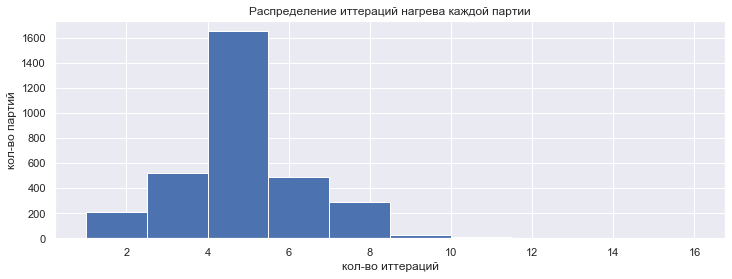

In [5]:
plt.hist(tables['data_arc']['key'].value_counts())
plt.title('Распределение иттераций нагрева каждой партии')
plt.xlabel('кол-во иттераций')
plt.ylabel('кол-во партий')

Кол-во иттераций нагрева партии от 1 до 16, но в основном 4-6.

Text(0, 0.5, 'кол-во партий')

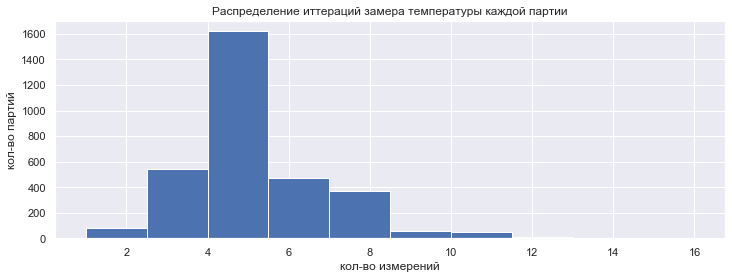

In [6]:
plt.hist(tables['data_temp']['key'].value_counts())
plt.title('Распределение иттераций замера температуры каждой партии')
plt.xlabel('кол-во измерений')
plt.ylabel('кол-во партий')

Кол-во иттераций измерения температуры и хим. анализа такое же 1-16, но распределение немного отличается

Text(0.5, 0, 'температура')

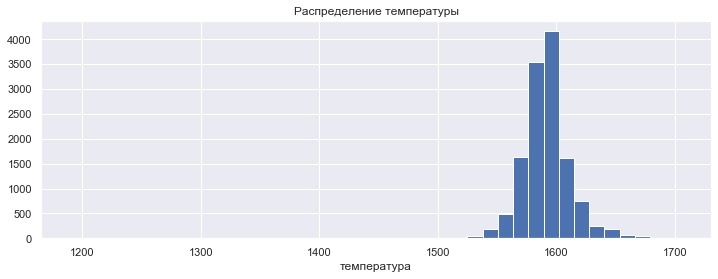

In [7]:
tables['data_temp']['Температура'].hist(bins=40)
plt.title('Распределение температуры')
plt.xlabel('температура')

Что значит температура меньше 1500? Это сбой в тех. процессе, сбой в измерении или нормальное явление?

In [8]:
tables['data_temp'][tables['data_temp']['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [9]:
tables['data_temp'][tables['data_temp']['key'] == 2052]

,key,Время замера,Температура
10127,2052,2019-07-21 14:51:40,1227.0
10128,2052,2019-07-21 14:52:21,1592.0
10129,2052,2019-07-21 15:06:31,1590.0
10130,2052,2019-07-21 15:15:24,1591.0
10131,2052,2019-07-21 15:24:06,1592.0


Видно что одно из измерений температуры в 6 партиях сильно выбивается - обычно при первом измерении показывет очень низкую температуру.

Рассмотрим весь процесс обработки для одной партии

In [10]:
for name in table_rus_name.keys():
    print('\n \033[1m', table_rus_name[name], '\033[0m')
    display(tables[name][tables[name]['key'] == 1568])


  Нагрев 


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7213,1568,2019-06-28 21:03:27,2019-06-28 21:06:42,0.803189,0.689613



  Измерение температуры и хим. анализ 


,key,Время замера,Температура
7728,1568,2019-06-28 21:07:26,1601.0
7729,1568,2019-06-28 21:14:20,1601.0
7730,1568,2019-06-28 21:14:52,1591.0



  Подача сыпучих материалов объем 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1510,1568,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256.0,NaN,150.0,207.0



  Подача сыпучих материалов время 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1510,1568,NaN,NaN,NaN,2019-06-28 21:08:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-28 21:05:08,NaN,2019-06-28 21:05:08,2019-06-28 21:05:08



  Подача проволки объем 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1489,1568,55.0368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



  Подача проволки время 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1489,1568,2019-06-28 21:07:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



  Обдувка газом 


,key,Газ 1
1565,1568,3.579623


Похоже что пропуски на этапе легирования обусловлены особенностью тех. процессов. Подаются разные сочетания материалов. Поэтому пропуски в этих таблицах можно будет заменить нулями.

<a id='2'></a>
# Предобработка

переименуем столбцы

In [11]:
columns = []
for i in tables.keys():
    columns.append(list(tables[i].columns))

print('Названия столбцов:', columns)

print('Названия датасетов:', tables.keys())

Названия столбцов: [['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность'], ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], ['key', 'Время замера', 'Температура'], ['key', 'Газ 1'], ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'], ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']]
Названия датасетов: dict_keys(['data_arc', 'data_wire', 'data_temp', 'data_gas', 'data_bulk', 'data_wire_time', 'data_bulk_time'])


In [12]:
# new names for columns in each dataset
arc = ['key', 'heat_start', 'heat_end', 'active_power', 'reactive_power']
wires = ['key'] + [f'wire_{i}' for i in range(1,10)]
temp = ['key', 'time', 'temp']
gas = ['key', 'gas']
bulks = ['key'] + [f'bulk_{i}' for i in range(1,16)]

tables['data_arc'].set_axis(arc, axis='columns', inplace=True)
tables['data_temp'].set_axis(temp, axis='columns', inplace=True)
tables['data_gas'].set_axis(gas, axis='columns', inplace=True)
tables['data_wire'].set_axis(wires, axis='columns', inplace=True)
tables['data_bulk'].set_axis(bulks, axis='columns', inplace=True)

Уберем отрицательные значения в столбце 'реактивная мощность'

In [13]:
tables['data_arc'] = tables['data_arc'][tables['data_arc']['reactive_power'] > 0]

Активная мощность - это действительная мощность, которая уходит на нагрев, а реактиваня - мнимая или потери. Активная мощность не может быть меньше реактивной, поэтому сразу уберем такие значения, если есть.

In [14]:
tables['data_arc']['diff'] = tables['data_arc']['active_power'] - tables['data_arc']['reactive_power']
tables['data_arc'] = tables['data_arc'][tables['data_arc']['diff'] > 0]

Уберем пропуски в температуре, так как это таргет и его не получится заполнить без лика.
И пропуски в таблице газ, так как это обязательный последний этап обработки

In [15]:
tables['data_temp'] = tables['data_temp'].dropna()
tables['data_gas'] = tables['data_gas'].dropna()

## Работа с признакми
1. Добавим полную мощность, соотношение активной к реактивной и удалим реактивную и активную, иначе они будут сильно коррелировать    
$S = \sqrt {P^2 + Q^2}$

In [16]:
tables['data_arc']['apparent_power'] = tables['data_arc'].apply(apperent_power, axis=1)
tables['data_arc']['power_ratio'] = tables['data_arc']['reactive_power'] / tables['data_arc']['active_power']
tables['data_arc'] = tables['data_arc'].drop(['active_power', 'reactive_power'], axis=1)

2. Добавим общюю длительность нагрева в мин

In [17]:
# changing type to datetime
tables['data_arc']['heat_start'] = pd.to_datetime(tables['data_arc']['heat_start'])
tables['data_arc']['heat_end'] = pd.to_datetime(tables['data_arc']['heat_end'])

tables['data_arc']['heat_duration'] = tables['data_arc']['heat_end'] - tables['data_arc']['heat_start'] 
tables['data_arc']['minutes'] = tables['data_arc']['heat_duration'] / np.timedelta64(1, "m")
#tables['data_arc'] = tables['data_arc'].drop(['heat_start', 'heat_end', 'heat_duration'], axis=1)
tables['data_arc'].head(2)

,key,heat_start,heat_end,diff,apparent_power,power_ratio,heat_duration,minutes
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.288975,1.193639,0.703937,00:03:48,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.285322,0.959010,0.645830,00:03:05,3.083333


сгруппируем по 'key' и получим признаки: общая мощность, среднее соотношение реактивной и активной мощности, общая продолжительность нагрева и кол-во иттераций нагрева

In [18]:
group_arc = tables['data_arc'].groupby('key').agg({'apparent_power':'sum',
                                                   'power_ratio':'mean', 
                                                   'minutes':['sum', 'count']},
                                                 ).reset_index()
group_arc.set_axis(['key', 'apparent_power','power_ratio', 'heat_duration',
                    'heat_iteration'], axis='columns', inplace=True)
group_arc.head(2)

,key,apparent_power,power_ratio,heat_duration,heat_iteration
0,1,5.826395,0.651695,18.300000,5
1,2,3.649216,0.645465,13.516667,4


In [19]:
group_arc.shape

(3210, 5)

3. Выделим первоначальную температуру как фичу и конечную, как целевую.          

Удалим наблюдения где только один замер температуры

In [20]:
group_temp = tables['data_temp'].groupby('key').count()
group_temp['temp'][group_temp['temp'] < 2]

key
195     1
279     1
2500    1
2501    1
2502    1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: temp, Length: 741, dtype: int64

In [21]:
keys_one_temp = list(group_temp['temp'][group_temp['temp'] < 2].index)
tables['data_temp'] = tables['data_temp'].query('key not in @keys_one_temp')

Для каждой партии найдем время первого и последнего замера температуры

In [22]:
tables['data_temp']['time'] = pd.to_datetime(tables['data_temp']['time'])

first_temp = tables['data_temp'].groupby('key').agg({'time':'min'})
target_key = tables['data_temp'].groupby('key').agg({'time':'max'})

целевой признак

In [23]:
target = tables['data_temp'].merge(target_key, on='time')
target.shape

(2475, 3)

первоначальная температура

In [24]:
tables['data_temp'] = tables['data_temp'].merge(first_temp, on='time')
tables['data_temp'].shape

(2475, 3)

In [25]:
tables['data_temp'] = tables['data_temp'].rename(columns={'temp':'first_temp'})

## Схлопнем таблицы
1. свести все таблицы в одну по key
2. key сделать индекосм
3. проверить получившуюс таблицу

In [26]:
features = tables['data_temp'] \
               .merge(group_arc, on='key', how='inner') \
               .merge(tables['data_gas'], on='key', how='inner') \
               .merge(tables['data_bulk'], on='key', how='inner') \
               .merge(tables['data_wire'], on='key', how='inner')

features.shape

(2326, 32)

In [27]:
features.head(2)

,key,time,first_temp,apparent_power,power_ratio,heat_duration,heat_iteration,gas,bulk_1,bulk_2,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:16:18,1571.0,5.826395,0.651695,18.300000,5,29.749986,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:37:27,1581.0,3.649216,0.645465,13.516667,4,12.555561,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 0 to 2325
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2326 non-null   int64         
 1   time            2326 non-null   datetime64[ns]
 2   first_temp      2326 non-null   float64       
 3   apparent_power  2326 non-null   float64       
 4   power_ratio     2326 non-null   float64       
 5   heat_duration   2326 non-null   float64       
 6   heat_iteration  2326 non-null   int64         
 7   gas             2326 non-null   float64       
 8   bulk_1          199 non-null    float64       
 9   bulk_2          13 non-null     float64       
 10  bulk_3          959 non-null    float64       
 11  bulk_4          812 non-null    float64       
 12  bulk_5          53 non-null     float64       
 13  bulk_6          437 non-null    float64       
 14  bulk_7          13 non-null     float64       
 15  bulk

Удалим столбцы где нет данных или слишком мало данных, менее 20

In [29]:
features = features.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13', 
                          'wire_4', 'wire_5', 'wire_7', 'wire_8', 'time'], axis=1)

Оставшиеся пропуски, которые связаны с подачей материалов заполним 0

In [30]:
features = features.fillna(0)
features.head(2)

,key,first_temp,apparent_power,power_ratio,heat_duration,heat_iteration,gas,bulk_1,bulk_3,bulk_4,...,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9
0,1,1571.0,5.826395,0.651695,18.300000,5,29.749986,0.0,0.0,43.0,...,0.0,0.0,206.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0
1,2,1581.0,3.649216,0.645465,13.516667,4,12.555561,0.0,0.0,73.0,...,0.0,0.0,206.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0


подгоним таргет по партиям

In [31]:
keys = list(features['key'].unique())
target = target.query('key in @keys').drop(['key', 'time'], axis=1)

In [32]:
print('размер датасета с признаками', features.shape)
print('размер таргета', target.shape)

размер датасета с признаками (2326, 22)
размер таргета (2326, 1)


Еще раз проверим признаки перед обучением моделей

In [33]:
features.describe()

,key,first_temp,apparent_power,power_ratio,heat_duration,heat_iteration,gas,bulk_1,bulk_3,bulk_4,...,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9
count,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,...,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000,2326.000000
mean,1250.928633,1586.707653,3.827456,0.739473,13.104256,4.576526,11.380246,3.432072,47.379192,37.351677,...,5.059329,4.247206,208.477214,153.941101,119.956148,102.469565,17.593841,3.239088,0.980082,0.317522
std,714.349884,28.298449,1.748250,0.064656,5.628065,1.622672,6.393647,12.419526,75.344735,58.665739,...,20.930503,22.529530,157.097655,81.390134,84.617626,43.558147,33.608894,27.960651,8.698835,3.458772
min,1.000000,1191.000000,0.257637,0.568125,1.016667,1.000000,0.008399,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,629.250000,1571.000000,2.611574,0.696324,9.316667,4.000000,7.284220,0.000000,0.000000,0.000000,...,0.000000,0.000000,105.000000,105.000000,0.000000,73.227958,0.000000,0.000000,0.000000,0.000000
50%,1254.500000,1587.000000,3.684137,0.731270,12.633333,4.000000,10.103073,0.000000,0.000000,0.000000,...,0.000000,0.000000,206.000000,149.000000,107.000000,101.119202,0.000000,0.000000,0.000000,0.000000
75%,1866.750000,1603.000000,4.794236,0.774975,16.183333,6.000000,14.217440,0.000000,80.000000,77.750000,...,0.000000,0.000000,282.750000,204.000000,204.000000,128.107975,23.102560,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,21.564771,0.994678,69.816667,15.000000,77.995040,185.000000,454.000000,281.000000,...,159.000000,313.000000,1849.000000,636.000000,405.000000,330.314424,282.780152,385.008668,180.454575,62.025600


In [34]:
features.head(3)

,key,first_temp,apparent_power,power_ratio,heat_duration,heat_iteration,gas,bulk_1,bulk_3,bulk_4,...,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9
0,1,1571.0,5.826395,0.651695,18.300000,5,29.749986,0.0,0.0,43.0,...,0.0,0.0,206.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0
1,2,1581.0,3.649216,0.645465,13.516667,4,12.555561,0.0,0.0,73.0,...,0.0,0.0,206.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0
2,3,1596.0,2.989534,0.631751,10.916667,5,28.554793,0.0,0.0,34.0,...,0.0,0.0,205.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0


### Анализ на мультиколлинеарность

In [35]:
features.corr()

,key,first_temp,apparent_power,power_ratio,heat_duration,heat_iteration,gas,bulk_1,bulk_3,bulk_4,...,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9
key,1.000000,-0.019330,-0.040708,0.128922,-0.053029,-0.062793,-0.043479,-0.077986,-0.006332,-0.025380,...,0.063260,0.034951,0.025484,-0.110374,-0.046815,-0.013345,0.044356,-0.027157,-0.008103,0.021454
first_temp,-0.019330,1.000000,-0.333169,0.076349,-0.293197,-0.128182,0.037586,0.072471,-0.104450,0.145117,...,0.035518,-0.087651,-0.058059,-0.130756,-0.039537,0.209618,-0.086716,-0.000133,0.019936,0.004348
apparent_power,-0.040708,-0.333169,1.000000,-0.203200,0.983117,0.766373,0.362968,0.092638,0.119013,-0.025502,...,0.007407,0.057597,0.494682,0.462551,0.359988,0.067402,0.053163,0.034582,0.045431,-0.013841
power_ratio,0.128922,0.076349,-0.203200,1.000000,-0.211828,-0.222540,-0.084298,0.108244,-0.153443,-0.003841,...,-0.015382,0.012062,-0.047035,-0.145679,-0.089263,-0.112525,-0.007145,-0.016065,0.005306,0.007093
heat_duration,-0.053029,-0.293197,0.983117,-0.211828,1.000000,0.799934,0.386888,0.101174,0.112658,-0.022799,...,0.000351,0.062723,0.483212,0.465674,0.330458,0.082964,0.053196,0.034089,0.033451,-0.010870
heat_iteration,-0.062793,-0.128182,0.766373,-0.222540,0.799934,1.000000,0.390489,0.094964,0.128482,0.000815,...,0.019065,0.042066,0.318470,0.333558,0.211043,0.167072,0.075953,0.058790,0.048840,-0.024999
gas,-0.043479,0.037586,0.362968,-0.084298,0.386888,0.390489,1.000000,0.234043,0.059720,0.017127,...,-0.008687,0.041971,0.216851,0.268085,0.043162,0.116809,0.105509,0.103340,0.108051,0.014009
bulk_1,-0.077986,0.072471,0.092638,0.108244,0.101174,0.094964,0.234043,1.000000,-0.011744,0.041632,...,-0.023275,-0.037919,0.325815,0.207601,-0.000812,0.013521,-0.009108,0.020231,0.148530,0.011034
bulk_3,-0.006332,-0.104450,0.119013,-0.153443,0.112658,0.128482,0.059720,-0.011744,1.000000,-0.295826,...,-0.085305,-0.007429,0.018666,0.010861,-0.012333,0.039621,0.095286,0.005733,0.007068,0.004584
bulk_4,-0.025380,0.145117,-0.025502,-0.003841,-0.022799,0.000815,0.017127,0.041632,-0.295826,1.000000,...,-0.084970,-0.119620,0.105613,-0.091384,0.101608,0.297357,-0.268209,-0.039325,-0.011512,-0.058229


Видим сильную линейную зависимость между новыми признаками `apparent_power` и `heat_duration`, поэтому удалим один из них - признак `heat_duration`

In [36]:
features = features.drop(['key', 'heat_duration'], axis=1)

<a id='3'></a>
# Модель

Выделим тестовую выборку и целевой признак

In [37]:
SEED = 999  # random_state

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED)

print('Размер обучающей выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)

print('Размер трейн таргета', target_train.shape)
print('Размер тестового таргета', target_test.shape)

Размер обучающей выборки (1860, 20)
Размер тестовой выборки (466, 20)
Размер трейн таргета (1860, 1)
Размер тестового таргета (466, 1)


Посмотрим на важность признаков

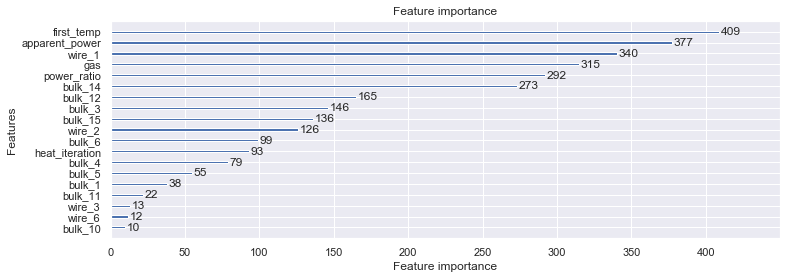

In [38]:
model = LGBMRegressor()
model.fit(features_train, target_train)

plot_importance(model)

Масштабируем признаки

In [39]:
scaler = StandardScaler().fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Создадим словарь с результатами

In [40]:
results = {
    'Constant_mean': [],
    'LinearRegression': [],
    'RandomForest': [],
    'CatBoost': [],
    'LGBM': [],   
}

### Константная модель

In [41]:
const_predict = np.array([int(target_test.mean())] * int(target_test.count()))

for i in range(2):
    results['Constant_mean'].append(mean_absolute_error(target_test, const_predict))

results

{'Constant_mean': [8.401287553648068, 8.401287553648068],
 'LinearRegression': [],
 'RandomForest': [],
 'CatBoost': [],
 'LGBM': []}

### LinearRegression

In [42]:
%%time
scores = cross_val_score(LinearRegression(), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error',
                        )

print(-np.mean(scores))
results['LinearRegression'].append(round(-np.mean(scores), 2))

6.376626209820342
CPU times: user 91.1 ms, sys: 15.2 ms, total: 106 ms
Wall time: 33.6 ms


In [43]:
lin_model = LinearRegression()
lin_model.fit(features_train, target_train)
lin_prediction = lin_model.predict(features_test)
lin_mae = mean_absolute_error(target_test, lin_prediction)

print('MAE на тестовой выборке:', lin_mae)
results['LinearRegression'].append(round(lin_mae, 2))

MAE на тестовой выборке: 6.519517481670756


### RandomForestRegressor

In [44]:
%%time
scores = cross_val_score(RandomForestRegressor(random_state=SEED), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error',
                        )

print(-np.mean(scores))
results['RandomForest'].append(round(-np.mean(scores), 2))

6.039591397849463
CPU times: user 4.65 s, sys: 159 ms, total: 4.81 s
Wall time: 4.37 s


Подберем гиперпараметры

```python
grid = {'n_estimators': [i for i in range(10, 400, 25)],
        'max_depth': [i for i in range(1, 9)],
        'min_samples_leaf': [i for i in range(1, 5)],
         }

model = RandomForestRegressor(random_state=SEED)
random_search = RandomizedSearchCV(model,
                                   grid,
                                   cv=5,
                                   random_state=SEED,
                                   scoring='neg_mean_absolute_error'
                                  )
random_search.fit(features_train, target_train)

params = random_search.best_params_
print(params)
```

```
{'n_estimators': 235, 'min_samples_leaf': 3, 'max_depth': 7}
```

In [45]:
forest_model = RandomForestRegressor(random_state=SEED,
                                     n_estimators=235, 
                                     min_samples_leaf=2, 
                                     max_depth=8,
                                    )
forest_model.fit(features_train, target_train)

forest_prediction = forest_model.predict(features_test)
forest_mae = mean_absolute_error(target_test, forest_prediction)

print("MAE на тестовой выборке: ", forest_mae)

MAE на тестовой выборке:  5.977924075379632


запишем получившийся результат в таблицу

In [46]:
results['RandomForest'].append(forest_mae)

### CatBoostRegressor

In [47]:
%%time
scores = cross_val_score(CatBoostRegressor(random_state=SEED, silent=True), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error',
                        )
print(-np.mean(scores))

results['CatBoost'].append(round(-np.mean(scores), 2))

6.018585566686384
CPU times: user 51.5 s, sys: 2.41 s, total: 53.9 s
Wall time: 8.37 s


```python

grid = {'learning_rate': [0.03, 0.1, 0.2],
        'depth': [i for i in range(2, 6)],
        'l2_leaf_reg': [i for i in range(1, 5)],
        'iterations': [i for i in range(100, 500, 50)],
         }

model = CatBoostRegressor(random_state=SEED, loss_function='MAE', silent=True)
random_search = model.randomized_search(grid,
                                        X=features_train,
                                        y=target_train,
                                        partition_random_seed=SEED,
                                        cv=5,
                                        verbose=0,
                                       )

params = random_search['params']
print(params)
```

```
{'depth': 3, 'l2_leaf_reg': 1, 'iterations': 150, 'learning_rate': 0.1}
```

In [48]:
%%time

cat_model = CatBoostRegressor(random_state=SEED, 
                              loss_function="MAE", 
                              depth=3, l2_leaf_reg=1, 
                              iterations=350, learning_rate=0.1
                             )

cat_model.fit(features_train, target_train, verbose=150)

cat_prediction = cat_model.predict(features_test)
cat_mae = mean_absolute_error(target_test, cat_prediction)

print('MAE на тестовой выборке:', cat_mae)

0:	learn: 7.8645689	total: 1.76ms	remaining: 615ms
150:	learn: 5.3190701	total: 147ms	remaining: 194ms
300:	learn: 4.8400646	total: 286ms	remaining: 46.6ms
349:	learn: 4.7255003	total: 342ms	remaining: 0us
MAE на тестовой выборке: 5.906443326596747
CPU times: user 1.84 s, sys: 137 ms, total: 1.98 s
Wall time: 379 ms


In [49]:
results['CatBoost'].append(round(cat_mae, 2))

### LGBMRegressor

In [50]:
%%time
scores = cross_val_score(LGBMRegressor(random_state=SEED), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error')

print(-np.mean(scores))
results['LGBM'].append(round(-np.mean(scores), 2))

6.18287825369976
CPU times: user 3.55 s, sys: 53.4 ms, total: 3.61 s
Wall time: 488 ms


```python
grid = {'learning_rate': [0.03, 0.1, 0.2],
        'max_depth': [i for i in range(2, 6)],
        'min_data_in_leaf': [i for i in range(1, 5)],
        'num_leaves': [i for i in range(10, 100, 10)],
        'num_iterations': [i for i in range(100, 500, 50)],
         }

model = LGBMRegressor(random_state=SEED)
random_search = RandomizedSearchCV(model,
                                   grid,
                                   random_state=SEED,
                                   scoring='neg_mean_absolute_error',
                                   cv=5,
                                  )

random_search.fit(features_train, target_train)

params = random_search.best_params_
print(params)
```

```
{'num_leaves': 30, 'num_iterations': 150, 'min_data_in_leaf': 2, 'max_depth': 5, 'learning_rate': 0.03}
```

In [51]:
lgbm_model = LGBMRegressor(random_state=SEED,
                           num_leaves=20, num_iterations=100, 
                           min_data_in_leaf=2, max_depth=5, learning_rate=0.07,
                          )

lgbm_model.fit(features_train, target_train, verbose=150)

lgbm_prediction = lgbm_model.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_prediction)

print('MAE на тестовой выборке:', lgbm_mae)

MAE на тестовой выборке: 5.843651160387731


In [52]:
results['LGBM'].append(round(lgbm_mae, 2))

<a id='4'></a>
# Выводы

In [53]:
pd.DataFrame(results, columns=results.keys(), index=['untuned', 'test'])

,Constant_mean,LinearRegression,RandomForest,CatBoost,LGBM
untuned,8.401288,6.38,6.040000,6.02,6.18
test,8.401288,6.52,5.977924,5.91,5.84


- Добавили новые фичи: первоначальная температура, полная мощность, соотношение рекаттивной и активной мощностей, длительность нагрева и кол-во иттераций нагрева
- Удалили лишние признаки с временем и признаки с маленьким кол-вом информации
- В данном проекте основная работа проходила над признаками, а гиперпараметры влияли на конечный результат в минимальной степени
- Все три модели показали хороший результат, но lightGBM чуть лучше остальных - MAE 5.84

Text(0.5, 1.0, 'MAE на тестовой выборке 5.84')

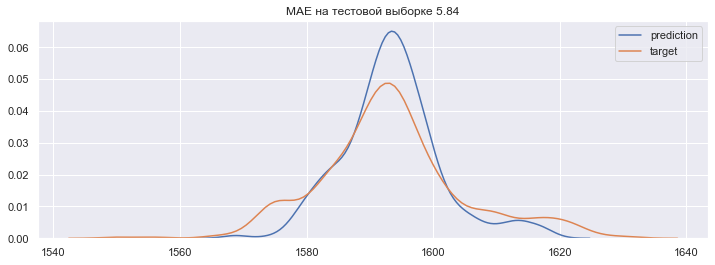

In [54]:
sns.kdeplot(lgbm_prediction, label='prediction')
sns.kdeplot(np.array(target_test['temp']), label='target')
plt.legend()
plt.title("MAE на тестовой выборке {}".format(round(lgbm_mae, 2)))